In [1]:

def resolve_proxy():
    import os
    os.environ['HTTP_PROXY']="http://10.8.0.1:8080"
    os.environ['HTTPS_PROXY']="http://10.8.0.1:8080"
    os.environ['http_proxy'] = "http://10.8.0.1:8080" 
    os.environ['https_proxy'] = "http://10.8.0.1:8080" 
resolve_proxy()

In [2]:
# https://dipy.org/documentation/1.6.0./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx
# Enables/disables interactive visualization
interactive = False
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.core.gradients import gradient_table

def get_nidata(download):
    from dipy.data import get_fnames

    if download == True:
        hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
        label_fname = get_fnames('stanford_labels')
    else:
        hardi_fname = '/home/ang/.dipy/stanford_hardi/HARDI150.nii.gz'
        hardi_bval_fname = '/home/ang/.dipy/stanford_hardi/HARDI150.bval'
        hardi_bvec_fname = '/home/ang/.dipy/stanford_hardi/HARDI150.bvec'
        label_fname = '/home/ang/.dipy/stanford_hardi/aparc-reduced.nii.gz'
    return hardi_fname, hardi_bval_fname, hardi_bvec_fname, label_fname

hardi_fname, hardi_bval_fname, hardi_bvec_fname, label_fname = get_nidata(download=False)
    # importing stanford hardi data with get_fnames

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname) # read labels of the NIFTI data

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

/home/ang/anaconda3/envs/SupWMA/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# mask generation for white matter regions
white_matter = (labels == 1) | (labels == 2)

In [4]:
data.shape

(81, 106, 76, 160)

## 2.1 Get the directions
from the Diffusion Dataset

In [5]:
from dipy.reconst.csdeconv import auto_response_ssst  # Constrained Spherical deconvolution
from dipy.reconst.shm import CsaOdfModel # Constant Solid Angle Orientation Distribution Function
from dipy.data import default_sphere # triangulated spheres' hemisphere
from dipy.direction import peaks_from_model # to calculate peaks of ODF, fiber directions in all voxels
# of the white matter

# data: first 3 dimensions are i,j,k voxel coordinates and last dims is number of non-weighted (S0s)
        # and diffusion weighted volumes
# gtab: gradient table involving bvals and bvecs
#         
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6) # this model based on the gtab estimates the ODF at each voxel
# sh_order describe the order of sh_coefficients

# constant solid angles are conical angle shapes from a point of origin
csa_peaks = peaks_from_model(csa_model, data, default_sphere, # this default sphere is providing discrete
                             # directions for evaluation
                             relative_peak_threshold=.8, #return only the peaks greater than m times the largest peak
                             min_separation_angle=45, # if 2 peaks are closer then the larger of the 2 is returned
                             mask=white_matter) # voxels that are false in mask are skipped and no peaks are returned
# returns: gfa, peak_directions, peak_values, peak_indices, odf, shm_coeffs

# TODO: does this model need to be CSA model for finding peaks? Can we use another model as in deep learning model
# to find those peaks

In [6]:
from dipy.viz import window, actor, has_fury
interactive = False

if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))
    # TODO: how can we plot this

    # window.record(scene, out_path='csa_direction_field.png', size=(900, 900))

    # if interactive:
    #     window.show(scene, size=(800, 800))

## 2.2 Fiber Tracking Termination

In [7]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25) 
# gfa: generalised fractional anisotropy

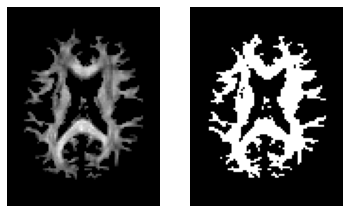

In [8]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

In [9]:
print(labels.shape)
print(data.shape)
# last value in the shape is the diffusion weighting

(81, 106, 76)
(81, 106, 76, 160)


In [10]:
print(bvals.shape)

(160,)


In [11]:
print(bvecs.shape)

(160, 3)


## 2.3 Begin Seeds for tracking

In [12]:
from dipy.tracking import utils

seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, 
                              affine, 
                              density=[2, 2, 2]) # size of the voxel, which is used as the seed for beginning tracking

In [13]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

In [14]:
from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='tractogram_EuDX.png', size=(10000, 10000))
    window.record
    # if interactive:
    #     window.show(scene)